In [15]:
import json
import random
import os

# ---------------- Global Variables ----------------
TOTAL_HINTS = 2
used_hints = 0
wrong_answers = []

SCORES_FILE = "scores.json"
HISTORY_FILE = "history.json"

# ---------------- Initialize JSON files if empty ----------------
for file in [SCORES_FILE, HISTORY_FILE]:
    if not os.path.exists(file) or os.path.getsize(file) == 0:
        with open(file, "w") as f:
            f.write("[]")

# ---------------- Utility Functions ----------------
def load_questions_by_difficulty(difficulty, count):
    """Load 'count' random questions of a given difficulty."""
    with open("questions.json", "r") as f:
        data = json.load(f)
    all_q = data["questions"].get(difficulty, [])
    for q in all_q:
        q["difficulty"] = difficulty
    random.shuffle(all_q)
    return all_q[:count]

def save_score(name, score, total):
    try:
        with open(SCORES_FILE, "r") as f:
            scores = json.load(f)
    except json.JSONDecodeError:
        scores = []
    scores.append({"name": name, "score": score, "total": total})
    scores = sorted(scores, key=lambda x: x['score'], reverse=True)[:5]  # top 5
    with open(SCORES_FILE, "w") as f:
        json.dump(scores, f, indent=2)
    return scores

def save_history(name, score, total):
    try:
        with open(HISTORY_FILE, "r") as f:
            history = json.load(f)
    except json.JSONDecodeError:
        history = []
    history.append({"name": name, "score": score, "total": total})
    with open(HISTORY_FILE, "w") as f:
        json.dump(history, f, indent=2)

def grade(percentage):
    if percentage >= 90:
        return "A"
    elif percentage >= 75:
        return "B"
    elif percentage >= 50:
        return "C"
    else:
        return "F"

# ---------------- Ask Question ----------------
def ask_question(q, q_num, diff_score):
    global used_hints
    print(f"\n--- Question {q_num} ---")
    options = q['options'].copy()
    random.shuffle(options)
    correct_option = options.index(q['options'][q['answer_index']])
    
    print(q['question'])
    for i, opt in enumerate(options):
        print(f"{i}. {opt}")

    print("\n💡 Hint available! Type 'h' to use (limited).")
    print("Type 's' to skip this question.\n")

    while True:
        user = input("Your answer (number/'h'/'s'): ").strip()

        # Hint
        if user.lower() == 'h':
            if used_hints >= TOTAL_HINTS:
                print("❌ You have used all your hints!")
            else:
                used_hints += 1
                print(f"💡 Hint ({used_hints}/{TOTAL_HINTS} used): {q['hint']}")
            continue

        # Skip
        elif user.lower() == 's':
            print(f"⏭️ Skipped! Correct answer: {options[correct_option]}\n")
            wrong_answers.append({
                "question": q['question'],
                "your_answer": "Skipped",
                "correct_answer": options[correct_option]
            })
            return 0

        # Answer
        elif user.isdigit():
            choice = int(user)
            if choice == correct_option:
                print(f"✅ Correct! +{diff_score} points\n")
                return diff_score
            else:
                print(f"❌ Wrong! Correct answer: {options[correct_option]}\n")
                wrong_answers.append({
                    "question": q['question'],
                    "your_answer": options[choice] if choice < len(options) else "Invalid",
                    "correct_answer": options[correct_option]
                })
                return 0
        else:
            print("❌ Invalid input! Enter option number, 'h' for hint, or 's' to skip.")

# ---------------- Start Quiz ----------------
def start_quiz():
    global used_hints, wrong_answers
    wrong_answers = []
    used_hints = 0

    print("\n🔥 Welcome to AI Quiz Bot! 🔥")
    name = input("Enter your name: ").strip()
    print("\nQuiz Start — Good luck!\n")

    # Load questions
    questions = []
    questions += load_questions_by_difficulty("easy", 3)
    questions += load_questions_by_difficulty("medium", 4)
    questions += load_questions_by_difficulty("hard", 3)
    random.shuffle(questions)

    difficulty_map = {"easy":1, "medium":2, "hard":3}
    score = 0

    for idx, q in enumerate(questions, start=1):
        diff_score = difficulty_map.get(q.get('difficulty', 'easy'), 1)
        score += ask_question(q, idx, diff_score)

    # ---------------- Retry Wrong Questions ----------------
    if wrong_answers:
        retry = input("\nDo you want to retry wrong/skipped questions? (y/n): ").strip().lower()
        if retry == 'y':
            temp_wrong = wrong_answers.copy()
            wrong_answers.clear()
            for idx, q in enumerate(temp_wrong, start=1):
                retry_q = {
                    "question": q["question"],
                    "options": [q["correct_answer"]],
                    "answer_index": 0,
                    "hint": "No hint available",
                    "difficulty": "easy"
                }
                score += ask_question(retry_q, idx, 1)

    # ---------------- Final Score & Feedback ----------------
    total_questions = len(questions)
    percentage = int((score / sum([difficulty_map[q.get('difficulty','easy')] for q in questions])) * 100)
    user_grade = grade(percentage)

    print("\n--- Quiz Completed ---")
    print("====================================")
    print(f"🎯 {name}, Your Total Score is: {score} / {sum([difficulty_map[q.get('difficulty','easy')] for q in questions])}")
    print(f"✅ Correct: {score} points")
    print(f"❌ Wrong/Skipped: {len(wrong_answers)}")
    print(f"📊 Percentage: {percentage}%")
    print(f"🏅 Grade: {user_grade}")
    print("====================================\n")

    # ---------------- Review Wrong Answers ----------------
    if wrong_answers:
        print("--- Review of Wrong/Skipped Answers ---")
        for w in wrong_answers:
            print(f"\n❌ {w['question']}")
            print(f"Your answer: {w['your_answer']}")
            print(f"Correct answer: {w['correct_answer']}")

    # ---------------- Save leaderboard & history ----------------
    top_scores = save_score(name, score, sum([difficulty_map[q.get('difficulty','easy')] for q in questions]))
    save_history(name, score, sum([difficulty_map[q.get('difficulty','easy')] for q in questions]))

    print("\n--- Top Scores ---")
    for idx, t in enumerate(top_scores, start=1):
        print(f"{idx}. {t['name']} - {t['score']} / {t['total']}")

# ---------------- Run Quiz ----------------
if __name__ == "__main__":
    start_quiz()



🔥 Welcome to AI Quiz Bot! 🔥

Quiz Start — Good luck!


--- Question 1 ---
What is the boiling point of water at sea level (°C)?
0. 90
1. 100
2. 95
3. 105

💡 Hint available! Type 'h' to use (limited).
Type 's' to skip this question.

❌ Invalid input! Enter option number, 'h' for hint, or 's' to skip.
✅ Correct! +2 points


--- Question 2 ---
Which famous scientist proposed the laws of motion and universal gravitation?
0. Newton
1. Galileo
2. Tesla
3. Einstein

💡 Hint available! Type 'h' to use (limited).
Type 's' to skip this question.

💡 Hint (1/2 used): He also invented calculus.
✅ Correct! +2 points


--- Question 3 ---
Which instrument is used to measure atmospheric pressure?
0. Anemometer
1. Hygrometer
2. Barometer
3. Thermometer

💡 Hint available! Type 'h' to use (limited).
Type 's' to skip this question.

✅ Correct! +2 points


--- Question 4 ---
What is the acceleration due to gravity on Earth (approx)? (m/s²)
0. 10.5
1. 9.8
2. 8.9
3. 9.2

💡 Hint available! Type 'h' to use (lim


📊 ML Model Results
MAE: 0.0693069306930667
RMSE: 0.0693069306930667


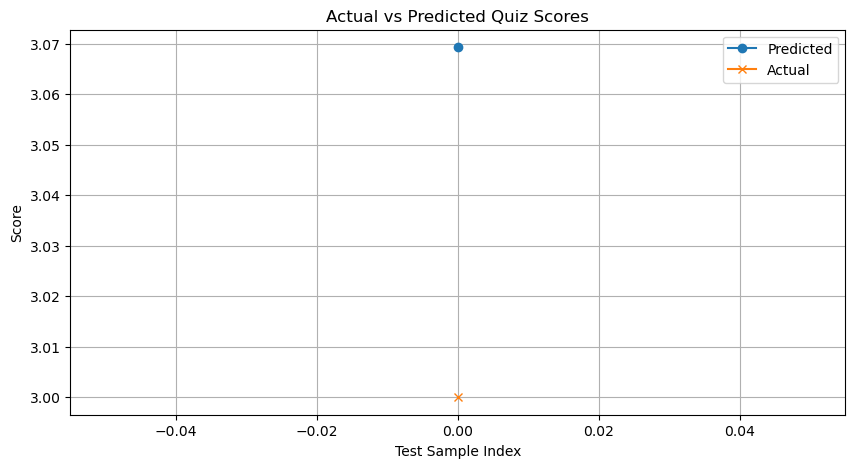


🔥 Anomalies (Unusual Scores):
   name  score  total  percentage
0  Aqsa      3     20        15.0

📈 Next Quiz Score Prediction per Player:
   name  predicted_next_score
0  Aqsa                  10.0
1  Umer                  12.0

🤖 Model saved as C:\Users\Administrator\Desktop\QUIZ BOT\quiz_model.pkl


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import IsolationForest
import pickle
import os

# ------------------ LOAD QUIZ HISTORY ------------------
history_path = r"C:\Users\Administrator\Desktop\QUIZ BOT\history.json"

if not os.path.exists(history_path):
    print("⚠ history.json not found. Play the quiz first!")
else:
    # Load data
    df = pd.read_json(history_path)
    if df.empty:
        print("⚠ history.json is empty.")
    else:
        df.columns = df.columns.str.strip().str.lower()
        
        # ------------------ FEATURE ENGINEERING ------------------
        df['percentage'] = (df['score'] / df['total']) * 100
        df['name_num'] = df['name'].astype('category').cat.codes
        
        # ------------------ FEATURES & TARGET ------------------
        X = df[['percentage', 'total', 'name_num']].fillna(0)
        y = df['score'].fillna(0)

        # ------------------ TRAIN-TEST SPLIT ------------------
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # ------------------ MODEL TRAINING ------------------
        model = LinearRegression()
        model.fit(X_train, y_train)

        # ------------------ PREDICTION & EVALUATION ------------------
        pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, pred)
        rmse = np.sqrt(mean_squared_error(y_test, pred))

        print("\n📊 ML Model Results")
        print("MAE:", mae)
        print("RMSE:", rmse)

        # ------------------ VISIBLE PLOT ------------------
        plt.figure(figsize=(10,5))
        plt.plot(range(len(pred)), pred, label="Predicted", marker='o')
        plt.plot(range(len(y_test)), y_test.values, label="Actual", marker='x')
        plt.title("Actual vs Predicted Quiz Scores")
        plt.xlabel("Test Sample Index")
        plt.ylabel("Score")
        plt.legend()
        plt.grid(True)
        plt.show()

        # ------------------ ANOMALY DETECTION ------------------
        iso = IsolationForest(contamination=0.1, random_state=42)
        df['anomaly'] = iso.fit_predict(df[['score']])
        anomalies = df[df['anomaly'] == -1]
        if not anomalies.empty:
            print("\n🔥 Anomalies (Unusual Scores):")
            print(anomalies[['name','score','total','percentage']])
        else:
            print("\nNo anomalies detected.")

        # ------------------ PREDICT NEXT SCORE ------------------
        print("\n📈 Next Quiz Score Prediction per Player:")
        next_scores = []
        for player in df['name'].unique():
            player_data = df[df['name'] == player].iloc[-1]  # use last quiz
            next_X = pd.DataFrame([{
                'percentage': player_data['percentage'],
                'total': player_data['total'],
                'name_num': player_data['name_num']
            }])
            pred_score = model.predict(next_X)[0]
            next_scores.append({'name': player, 'predicted_next_score': round(pred_score,2)})
        next_scores_df = pd.DataFrame(next_scores)
        print(next_scores_df)

        # ------------------ SAVE MODEL ------------------
        model_path = r"C:\Users\Administrator\Desktop\QUIZ BOT\quiz_model.pkl"
        with open(model_path, "wb") as f:
            pickle.dump(model, f)
        print(f"\n🤖 Model saved as {model_path}")
